In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [38]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [39]:
fill_categorical = df.select_dtypes(include=['object']).columns
fill_numerical = df.select_dtypes(include=['number']).columns

df[fill_categorical] = df[fill_categorical].fillna('NA')
df[fill_numerical] = df[fill_numerical].fillna(0.0)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [40]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [41]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count','lead_score']

categorical = [
    'lead_source',
    'industry',
    'employment_status',
    'location',
]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
coverted_decision = (y_pred >= 0.5)
(y_val == coverted_decision).mean()

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.8054607508532423)

In [42]:
from sklearn.metrics import roc_auc_score

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f"{col}: {auc:.3f}")


number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


In [43]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict_proba(X_val)[:, 1]


auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))

0.817


In [44]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

   
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    scores.append((t, precision, recall))

df_pr = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])


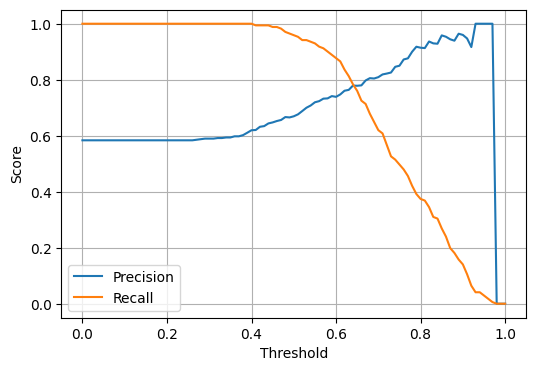

In [45]:
plt.figure(figsize=(6, 4))
plt.plot(df_pr.threshold, df_pr.precision, label='Precision')
plt.plot(df_pr.threshold, df_pr.recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


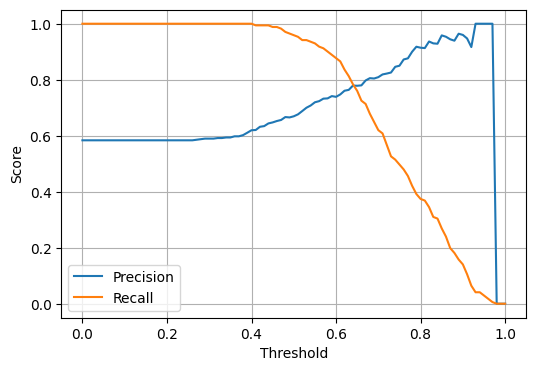

In [ ]:
from sklearn.metrics import precision_score, recall_score


thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred >= t)
    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

for t in thresholds:
    y_pred_bin = (y_pred >= t) 
    p = precision_score(y_val, y_pred_bin)
    r = recall_score(y_val, y_pred_bin)
    
  
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
        
    scores.append((t, p, r, f1))

df_f1 = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1'])

best = df_f1.loc[df_f1.f1.idxmax()]
print(best)


threshold    0.570000
precision    0.732394
recall       0.912281
f1           0.812500
Name: 57, dtype: float64


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
from sklearn.model_selection import KFold

In [53]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [57]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


In [58]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC scores:', scores)
print('Mean: %.3f, Std: %.3f' % (np.mean(scores), np.std(scores)))


AUC scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean: 0.822, Std: 0.036


In [ ]:


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_score = np.round(np.mean(scores), 3)
    std_score = np.round(np.std(scores), 3)
    results.append((C, mean_score, std_score))
    print(f"C={C}  Mean AUC={mean_score},  Std={std_score}")

df_results = pd.DataFrame(results, columns=['C', 'mean', 'std'])
best = df_results.sort_values(by=['mean', 'std', 'C'], ascending=[False, True, True]).iloc[0]
print("\nBest C:", best.C)


C=1e-06  Mean AUC=0.56,  Std=0.024
C=0.001  Mean AUC=0.867,  Std=0.029
C=1  Mean AUC=0.822,  Std=0.036

Best C: 0.001
